<div style="text-align:center; background-color:#f0f0f0; padding:20px; border-radius:10px;">
    <h1 style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#333; font-size:3em; font-weight:bold;">Data-related Innovation in Finance</h1>
    <p style="font-family: 'Garamond', serif; font-size:1.5em; color:#555; margin-top:0;">Personal Analysis of Stocks & Cryptocurrencies</p>
    <p style="font-family: 'Arial', sans-serif; font-size:1.2em; color:#777; margin-top:0;">Author: Antoine BUFFANDEAU</p>
</div>

<div class="alert alert-block alert-info" style = "font-family: Cambria Math;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 1.0px; padding: 3.5px" >
The rendering (display/design) of this notebbok <b>doesn't function</b> properly on </b>Google Collab!</b>  
Please open it on Visual Studio Code for better rendering.

This notebook is public on <b>GitHub</b> at this link:  
  <a href="https://github.com/AntoineBuffandeau/Data_analysis_on_stocks" target="_blank" style="color: #007acc; font-weight: bold;">https://github.com/AntoineBuffandeau/Data_analysis_on_stocks</a>
</div>

<div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466">

## TABLE OF CONTENTS

</div>

* [Introduction](#0)
* [PACKAGE IMPORTS](#1)
* [FUNCTIONS](#2)
* [Network Analysis of Stocks](#3)
    * [Import of historical data for CAC40 components from 2018 to 2023](#3a)
* [Network Analysis of Cryptocurrencies](#4)
* [Modelling and Assessing Financial Contagion and Stability](#5)
* [Conclusion](#6)

<a id="0"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">INTRODUCTION<br></div>

["A review of two decades of correlations, hierarchies, networks and clustering in financial markets"](https://arxiv.org/abs/1703.00485)

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">PACKAGE IMPORTS<br></div>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("Numpy version:",np.__version__)
print("Pandas version:", pd.__version__)
print("Yahoo Finance version:", yf.__version__)
print("NetWorkX:", nx.__version__)
print("Seaborn version:", sns.__version__)

Numpy version: 1.26.4
Pandas version: 2.2.1
Yahoo Finance version: 0.2.44
NetWorkX: 3.3
Seaborn version: 0.13.2


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">FUNCTIONS<br></div>

In [3]:
def plot_heatmap(matrix, title):
    """
    Plots a heatmap for a given matrix.

    Parameters:
    - matrix : pd.DataFrame or np.array
        -> The matrix to visualize, typically a correlation matrix.
    - title : str
        -> Title for the heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=False, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

def stronger_corr(matrix):
    """
    Identifies the top 10 strongest correlation pairs in a correlation matrix.

    Parameter:
    - matrix : pd.DataFrame
        -> A correlation matrix with stock tickers as both rows and columns.
    """
    corr_pairs = matrix.unstack()
    filtered_corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
    sorted_corr_pairs = filtered_corr_pairs.sort_values(ascending=False)
    top_10_correlations = sorted_corr_pairs.head(10)
    print("Top 10 strongest correlations:")
    print(top_10_correlations)

In [4]:
def plot_times_series(matrix):
    """
    Plots time series data for stock closing prices.

    Parameters:
    - matrix : pd.DataFrame
        -> DataFrame with time series data for stock prices, where each column represents a different stock and rows represent time.
    """
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(matrix)

    #Formatting
    ax.set_title('Close Price Index (DAX30 Stocks)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Time (format \'yyyy\')', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Price Index (in EUR)', fontsize = 16, fontdict=dict(weight='bold'))

    plt.tick_params(axis='y', which='major', labelsize=16)
    plt.tick_params(axis='x', which='major', labelsize=16)
    ax.get_legend().set_visible(True)
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    plt.show()

def plot_trading_volumes(matrix):
    """
    Plots time series data for trading volumes.

    Parameters:
    - matrix : pd.DataFrame
        -> DataFrame with time series data for trading volumes, where each column represents a different stock and rows represent time.
    """
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(matrix)

    # Formatting
    ax.set_title('Trading Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Time', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Trading Volume', fontsize = 16, fontdict=dict(weight='bold'))

    plt.tick_params(axis='y', which='major', labelsize=16)
    plt.tick_params(axis='x', which='major', labelsize=16)
    ax.get_legend().set_visible(True)
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [5]:
def create_correlation_network(correlation_matrix, threshold=0.5):
    """
    Creates a correlation network from a correlation matrix by adding edges between stocks with a correlation above a specified threshold.

    Parameters:
    - correlation_matrix : pd.DataFrame
        -> A correlation matrix where each row and column represent stocks.
    - threshold : float, optional
        -> The correlation threshold above which an edge is added between nodes. Default is 0.5.

    Returns:
    - G : networkx.Graph
        -> A NetworkX graph where nodes represent stocks and edges represent correlations above the specified threshold.
    """
    G = nx.Graph()
    G.add_nodes_from(correlation_matrix.columns)   #adding nodes for each stock in the correlation matrix

    #Iteration which adds an edge between the stocks if the correlation exceeds the threshold
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if correlation_matrix.iloc[i, j] > threshold:
                G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j],
                           weight=correlation_matrix.iloc[i, j])
                
    return G

def visualize_correlation_network(G, threshold, node_size=500, node_color="skyblue", edge_cmap=plt.cm.Blues, edge_vmin=0.5, edge_vmax=1):
    """
    Visualizes a correlation network with edges weighted by correlation values.

    Parameters:
    - G : networkx.Graph
        -> The correlation network graph.
    - threshold : float
        -> Correlation threshold value used to create the network.
    - node_size : int, optional
        -> Size of nodes in the plot (default: 500).
    - node_color : str, optional
        -> Color of the nodes (default: "skyblue").
    - edge_cmap : matplotlib.colors.Colormap, optional
        -> Colormap for edge colors based on weights (default: plt.cm.Blues).
    - edge_vmin : float, optional
        -> Minimum value for colormap normalization (default: 0.5).
    - edge_vmax : float, optional
        -> Maximum value for colormap normalization (default: 1).
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, ax=ax)

    edges = G.edges(data=True)
    edge_weights = [d['weight'] for (u, v, d) in edges]

    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_weights,
                           edge_cmap=edge_cmap, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=2, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", ax=ax)
    ax.set_title(f"Network of Stock Correlations (Threshold: {threshold})")
    sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=edge_vmin, vmax=edge_vmax))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Correlation Strength')
    plt.show()


<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">Network Analysis of Stocks<br></div>

<a id="3a"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">Import of historical data for CAC40 components from 2018 to 2023<br></div>

| Companies                        | Ticker Yahoo       | 2018 | 2019 | 2020 | 2021 | 2022 | 2023 | 2024 |
|------------------------------------|--------------------|------|------|------|------|------|------|------|
| Accor                              | AC.PA              | X    | X    | X    | X    | X    | X    | X    |
| Airbus                             | AIR.PA             | X    | X    | X    | X    | X    | X    | X    |
| Air Liquide                        | AI.PA              | X    | X    | X    | X    | X    | X    | X    |
| Alstom                             | ALO.PA             | X    | X    | X    | X    | X    | X    | X    |
| ArcelorMittal                      | MT.AS              | X    | X    | X    | X    |      |      |      |
| Atos                               | ATO.PA             | X    | X    | X    | X    |      |      |      |
| Axa                                | CS.PA              | X    | X    | X    | X    | X    | X    | X    |
| BNP Paribas                        | BNP.PA             | X    | X    | X    | X    | X    | X    | X    |
| Bouygues                           | EN.PA              | X    | X    | X    | X    | X    | X    | X    |
| Capgemini                          | CAP.PA             | X    | X    | X    | X    | X    | X    | X    |
| Carrefour                          | CA.PA              | X    | X    | X    | X    | X    | X    | X    |
| Crédit Agricole                    | ACA.PA             | X    | X    | X    | X    | X    | X    | X    |
| Danone                             | BN.PA              | X    | X    | X    | X    | X    | X    | X    |
| Dassault Systèmes                  | DSY.PA             | X    | X    | X    | X    | X    | X    | X    |
| Engie                              | ENGI.PA            | X    | X    | X    | X    | X    | X    | X    |
| Essilor/EssilorLuxottica           | EL.PA              | X    | X    | X    | X    | X    | X    | X    |
| Hermès                             | RMS.PA             | X    | X    | X    | X    | X    | X    | X    |
| Kering                             | KER.PA             | X    | X    | X    | X    | X    | X    | X    |
| L’Oréal                            | OR.PA              | X    | X    | X    | X    | X    | X    | X    |
| Legrand                            | LR.PA              | X    | X    | X    | X    | X    | X    | X    |
| LVMH                               | MC.PA              | X    | X    | X    | X    | X    | X    | X    |
| Michelin                           | ML.PA              | X    | X    | X    | X    | X    | X    | X    |
| Orange                             | ORA.PA             | X    | X    | X    | X    | X    | X    | X    |
| Pernod Ricard                      | RI.PA              | X    | X    | X    | X    | X    | X    | X    |
| Peugeot                            | UG.PA              | X    |      |      |      |      |      |      |
| Publicis                           | PUB.PA             | X    | X    | X    | X    | X    | X    | X    |
| Renault                            | RNO.PA             | X    | X    | X    | X    | X    | X    | X    |
| Safran                             | SAF.PA             | X    | X    | X    | X    | X    | X    | X    |
| Saint-Gobain                       | SGO.PA             | X    | X    | X    | X    | X    | X    | X    |
| Sanofi                             | SAN.PA             | X    | X    | X    | X    | X    | X    | X    |
| Schneider Electric                 | SU.PA              | X    | X    | X    | X    | X    | X    | X    |
| Société Générale                   | GLE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Solvay                             | SOLB.BR            | X    | X    |      |      |      |      |      |
| STMicroelectronics                 | STMPA.PA             | X    | X    | X    | X    | X    | X    | X    |
| TechnipFMC                         | FTI.PA             | X    | X    | X    |      |      |      |      |
| Thales                             | HO.PA              | X    | X    | X    | X    | X    | X    | X    |
| Total/TotalEnergies                | TTE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Unibail-Rodamco-Westfield          | URW.PA             | X    | X    | X    | X    | X    | X    | X    |
| Valeo                              | FR.PA              | X    | X    | X    | X    | X    | X    | X    |
| Veolia                             | VIE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Vinci                              | DG.PA              |      | X(N) | X    | X    | X    | X    | X    |
| Worldline                          | WLN.PA             |      |      | X(N) | X    | X    | X    | X    |
| Teleperformance                    | TEP.PA             |      |      | X(N) | X    | X    | X    | X    |
| Eurofins Scientific                | ERF.PA             |      |      |      | X(N) | X    | X    | X    |
| Stellantis                         | STLA.PA            |      |      |      |      | X(N) | X    | X    |


Comments : 

X : Indicates that the company was part of the CAC40 in that year ;

(N) : Indicates that a company entered the CAC40 for that year.

In [6]:
#I have arbitrarily chosen here to select only the stock names that remained in the CAC40 list from 2018 to 2023.
cac40_tickers = [
    'AC.PA',   # Accor
    'AI.PA',   # Air Liquide
    'AIR.PA',  # Airbus
    'ALO.PA',  # Alstom
    'BNP.PA',  # BNP Paribas
    'EN.PA',   # Bouygues
    'CAP.PA',  # Capgemini
    'CA.PA',   # Carrefour
    'ACA.PA',  # Crédit Agricole
    'BN.PA',   # Danone
    'DSY.PA',  # Dassault Systèmes
    'ENGI.PA', # Engie
    'EL.PA',   # EssilorLuxottica
    'RMS.PA',  # Hermès
    'KER.PA',  # Kering
    'OR.PA',   # L'Oréal
    'LR.PA',   # Legrand
    'MC.PA',   # LVMH
    'ML.PA',   # Michelin
    'ORA.PA',  # Orange
    'PUB.PA',  # Publicis
    'RI.PA',   # Pernod Ricard
    'SGO.PA',  # Saint-Gobain
    'SAN.PA',  # Sanofi
    'SU.PA',   # Schneider Electric
    'GLE.PA',  # Société Générale
    'STMPA.PA',  # STMicroelectronics
    'HO.PA',   # Thales
    'URW.PA',  # Unibail-Rodamco-Westfield
    'FR.PA',   # Valeo
    'VIE.PA',  # Veolia
]

In [7]:
data = yf.download(cac40_tickers, start='2018-01-01', end='2023-12-31')
data.shape  #should have: 31*6 columns ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] and less than 365*5 lines (because of workdays)

[*********************100%***********************]  31 of 31 completed


(1538, 186)

In [8]:
data.shape

(1538, 186)

In [9]:
data.head()

Price                      Adj Close                                  \
Ticker                         AC.PA    ACA.PA      AI.PA     AIR.PA   
Date                                                                   
2018-01-02 00:00:00+00:00  39.639462  8.694454  68.072739  77.157585   
2018-01-03 00:00:00+00:00  39.484482  8.747355  68.593864  78.435005   
2018-01-04 00:00:00+00:00  39.748859  9.142557  70.157249  80.020111   
2018-01-05 00:00:00+00:00  39.903847  9.126998  70.743530  79.814972   
2018-01-08 00:00:00+00:00  40.459969  9.226577  71.525208  80.766045   

Price                                                                  \
Ticker                        ALO.PA      BN.PA     BNP.PA      CA.PA   
Date                                                                    
2018-01-02 00:00:00+00:00  27.346342  54.851501  37.975792  14.595326   
2018-01-03 00:00:00+00:00  27.684729  55.217331  38.312176  14.639627   
2018-01-04 00:00:00+00:00  27.960163  56.036495  39.003319  14.756419   
2018-01-05 00:00:00+00:00  28.251328  57.062416  39.076714  14.913489   
2018-01-08 00:00:00+00:00  28.290676  56.680676  39.449802  14.450338   

Price                                            ...   Volume                  \
Ticker                        CAP.PA     DSY.PA  ...   ORA.PA  PUB.PA   RI.PA   
Date                                             ...                            
2018-01-02 00:00:00+00:00  88.655792  17.082813  ...  5623409  723777  327359   
2018-01-03 00:00:00+00:00  90.446800  17.291754  ...  5713414  936153  331727   
2018-01-04 00:00:00+00:00  90.760239  17.338186  ...  7180972  934769  412113   
2018-01-05 00:00:00+00:00  91.790077  17.516171  ...  5739730  827513  431872   
2018-01-08 00:00:00+00:00  91.700539  17.539387  ...  4569150  660005  439856   

Price                                                                        \
Ticker                    RMS.PA   SAN.PA   SGO.PA STMPA.PA    SU.PA URW.PA   
Date                                                                          
2018-01-02 00:00:00+00:00  36036  2251997  1271328  1774856  1173030    NaN   
2018-01-03 00:00:00+00:00  24416  2178460  2049422  2211658  1245073    NaN   
2018-01-04 00:00:00+00:00  39774  2753081  1728114  2546492  1384025    NaN   
2018-01-05 00:00:00+00:00  40301  2582924  1207486  1948360  1126714    NaN   
2018-01-08 00:00:00+00:00  37191  1847656  1265243  2064515  1169355    NaN   

Price                               
Ticker                      VIE.PA  
Date                                
2018-01-02 00:00:00+00:00  1348972  
2018-01-03 00:00:00+00:00  2210552  
2018-01-04 00:00:00+00:00  1977720  
2018-01-05 00:00:00+00:00  1885498  
2018-01-08 00:00:00+00:00  1561941  

[5 rows x 186 columns]

In [10]:
nan_count = data.isna().sum()
nan_count_filtered = nan_count[nan_count > 0]
print("Stocks with NaN values:", nan_count_filtered)

Stocks with NaN values: Price      Ticker
Adj Close  URW.PA    1355
Close      URW.PA    1355
High       URW.PA    1355
Low        URW.PA    1355
Open       URW.PA    1355
Volume     URW.PA    1355
dtype: int64


We observe that the stock 'URW.PA' might be problematic due to missing data. In order to ensure it doesn’t affect analyses, we decided to drop it.

In [11]:
data.columns

MultiIndex([('Adj Close',    'AC.PA'),
            ('Adj Close',   'ACA.PA'),
            ('Adj Close',    'AI.PA'),
            ('Adj Close',   'AIR.PA'),
            ('Adj Close',   'ALO.PA'),
            ('Adj Close',    'BN.PA'),
            ('Adj Close',   'BNP.PA'),
            ('Adj Close',    'CA.PA'),
            ('Adj Close',   'CAP.PA'),
            ('Adj Close',   'DSY.PA'),
            ...
            (   'Volume',   'ORA.PA'),
            (   'Volume',   'PUB.PA'),
            (   'Volume',    'RI.PA'),
            (   'Volume',   'RMS.PA'),
            (   'Volume',   'SAN.PA'),
            (   'Volume',   'SGO.PA'),
            (   'Volume', 'STMPA.PA'),
            (   'Volume',    'SU.PA'),
            (   'Volume',   'URW.PA'),
            (   'Volume',   'VIE.PA')],
           names=['Price', 'Ticker'], length=186)

In [12]:
data = data.drop(columns='URW.PA', level=1)
data.columns

MultiIndex([('Adj Close',    'AC.PA'),
            ('Adj Close',   'ACA.PA'),
            ('Adj Close',    'AI.PA'),
            ('Adj Close',   'AIR.PA'),
            ('Adj Close',   'ALO.PA'),
            ('Adj Close',    'BN.PA'),
            ('Adj Close',   'BNP.PA'),
            ('Adj Close',    'CA.PA'),
            ('Adj Close',   'CAP.PA'),
            ('Adj Close',   'DSY.PA'),
            ...
            (   'Volume',    'OR.PA'),
            (   'Volume',   'ORA.PA'),
            (   'Volume',   'PUB.PA'),
            (   'Volume',    'RI.PA'),
            (   'Volume',   'RMS.PA'),
            (   'Volume',   'SAN.PA'),
            (   'Volume',   'SGO.PA'),
            (   'Volume', 'STMPA.PA'),
            (   'Volume',    'SU.PA'),
            (   'Volume',   'VIE.PA')],
           names=['Price', 'Ticker'], length=180)

'URW.PA' was removed due to missing data to prevent it from skewing the analysis results. This approach was chosen to maintain data integrity and ensure reliable analyses (correlations or metrics in network analysis) that require complete datasets."

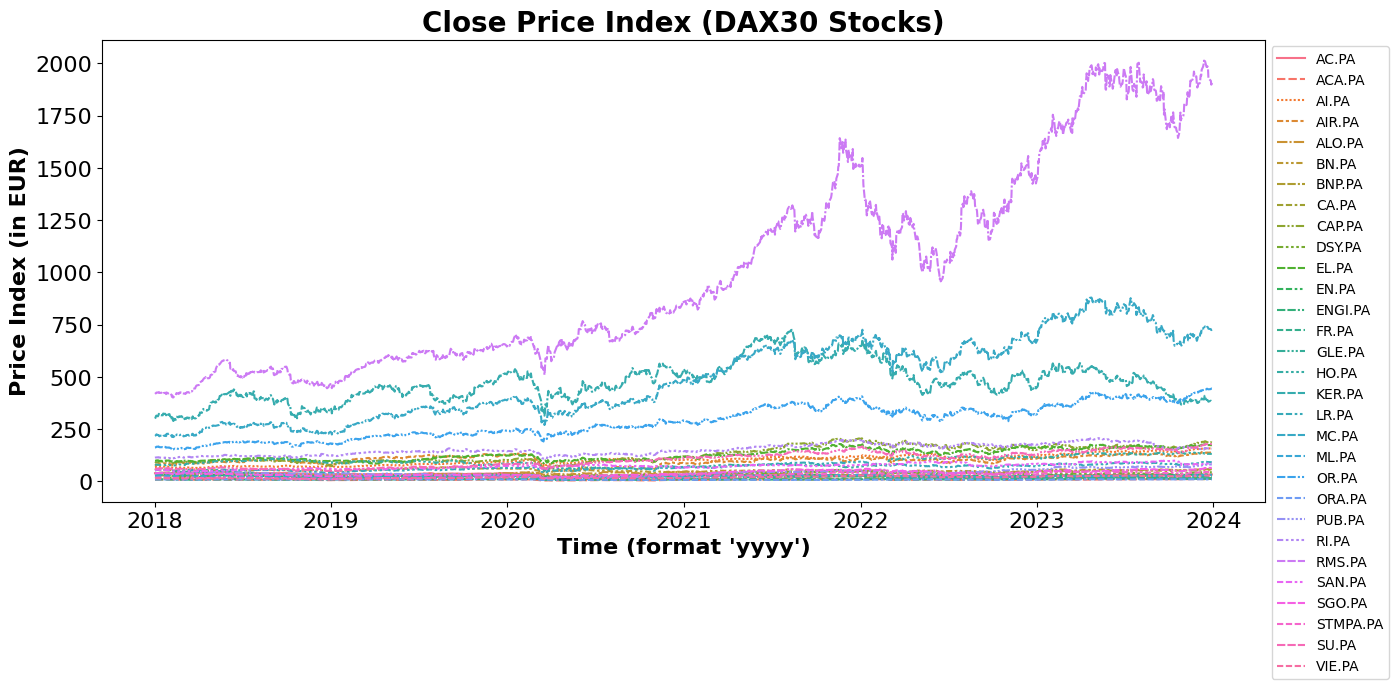

In [13]:
plot_times_series(data['Adj Close'])

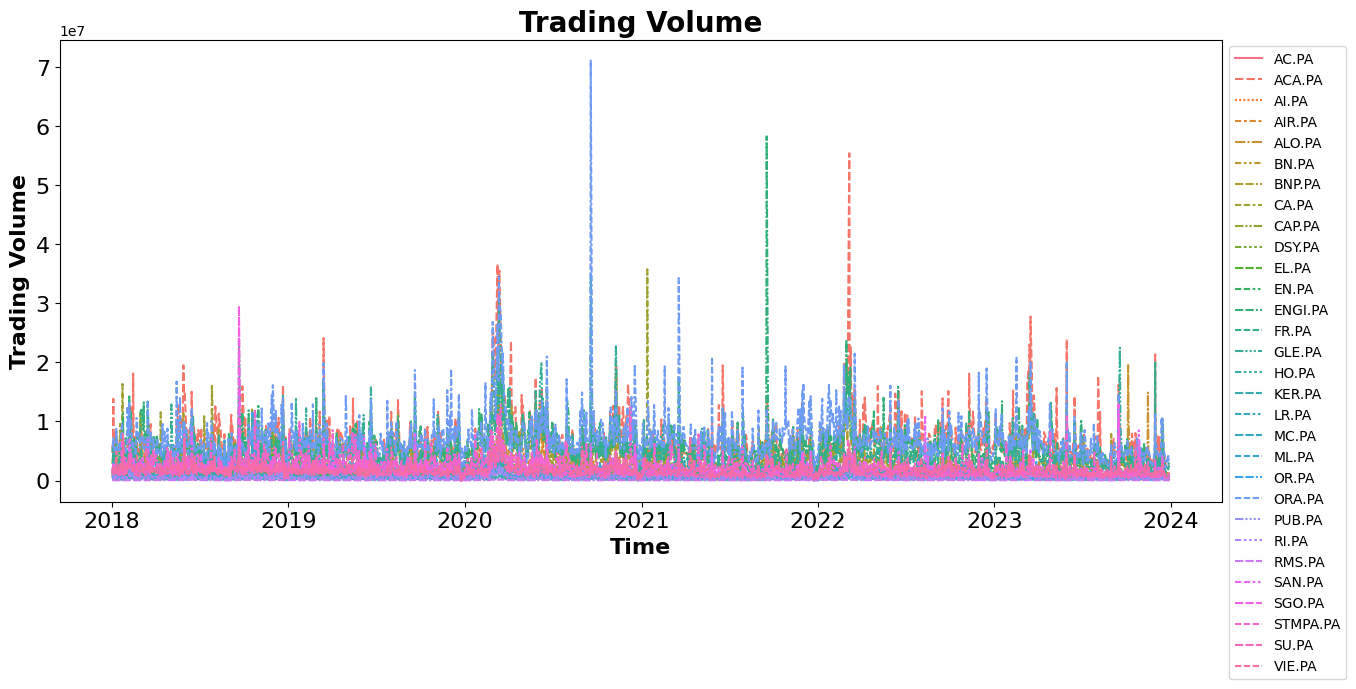

In [14]:
plot_trading_volumes(data['Volume'])

In [15]:
returns = data['Adj Close'].pct_change().dropna()
correlation_matrix = returns.corr()
correlation_matrix

Ticker,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,DSY.PA,...,OR.PA,ORA.PA,PUB.PA,RI.PA,RMS.PA,SAN.PA,SGO.PA,STMPA.PA,SU.PA,VIE.PA
Ticker,,,,,,,,,,,,,,,,,,,,,
AC.PA,1.000000,0.624212,0.390209,0.676782,0.355420,0.316970,0.629834,0.259378,0.468834,0.278106,...,0.355822,0.311917,0.485111,0.410814,0.394524,0.189882,0.528268,0.440400,0.496618,0.494808
ACA.PA,0.624212,1.000000,0.474038,0.602808,0.391980,0.329895,0.877714,0.334556,0.480663,0.261272,...,0.374140,0.415306,0.527005,0.354380,0.378597,0.199428,0.648546,0.482414,0.572410,0.522123
AI.PA,0.390209,0.474038,1.000000,0.458361,0.364076,0.470670,0.465168,0.332811,0.495890,0.450373,...,0.580845,0.432939,0.391253,0.471490,0.545429,0.371717,0.549614,0.497649,0.652442,0.504081
AIR.PA,0.676782,0.602808,0.458361,1.000000,0.379415,0.332264,0.618781,0.225661,0.504294,0.300032,...,0.377489,0.288218,0.429831,0.404318,0.442788,0.209021,0.530702,0.453505,0.534799,0.499226
ALO.PA,0.355420,0.391980,0.364076,0.379415,1.000000,0.227798,0.418951,0.177847,0.345228,0.231972,...,0.288037,0.209296,0.295172,0.288410,0.317991,0.160851,0.445304,0.348900,0.435659,0.367433
BN.PA,0.316970,0.329895,0.470670,0.332264,0.227798,1.000000,0.341784,0.341440,0.290773,0.210923,...,0.461827,0.416708,0.306532,0.463001,0.285494,0.390219,0.335745,0.237977,0.365767,0.440950
BNP.PA,0.629834,0.877714,0.465168,0.618781,0.418951,0.341784,1.000000,0.332605,0.463505,0.223760,...,0.381968,0.396677,0.529893,0.362801,0.379035,0.210214,0.650326,0.471622,0.578515,0.526160
CA.PA,0.259378,0.334556,0.332811,0.225661,0.177847,0.341440,0.332605,1.000000,0.140375,0.076465,...,0.221676,0.384290,0.279132,0.178197,0.117071,0.207434,0.298912,0.173182,0.283056,0.270529
CAP.PA,0.468834,0.480663,0.495890,0.504294,0.345228,0.290773,0.463505,0.140375,1.000000,0.609291,...,0.450187,0.214274,0.388176,0.437726,0.518633,0.221520,0.536677,0.575712,0.588900,0.488386


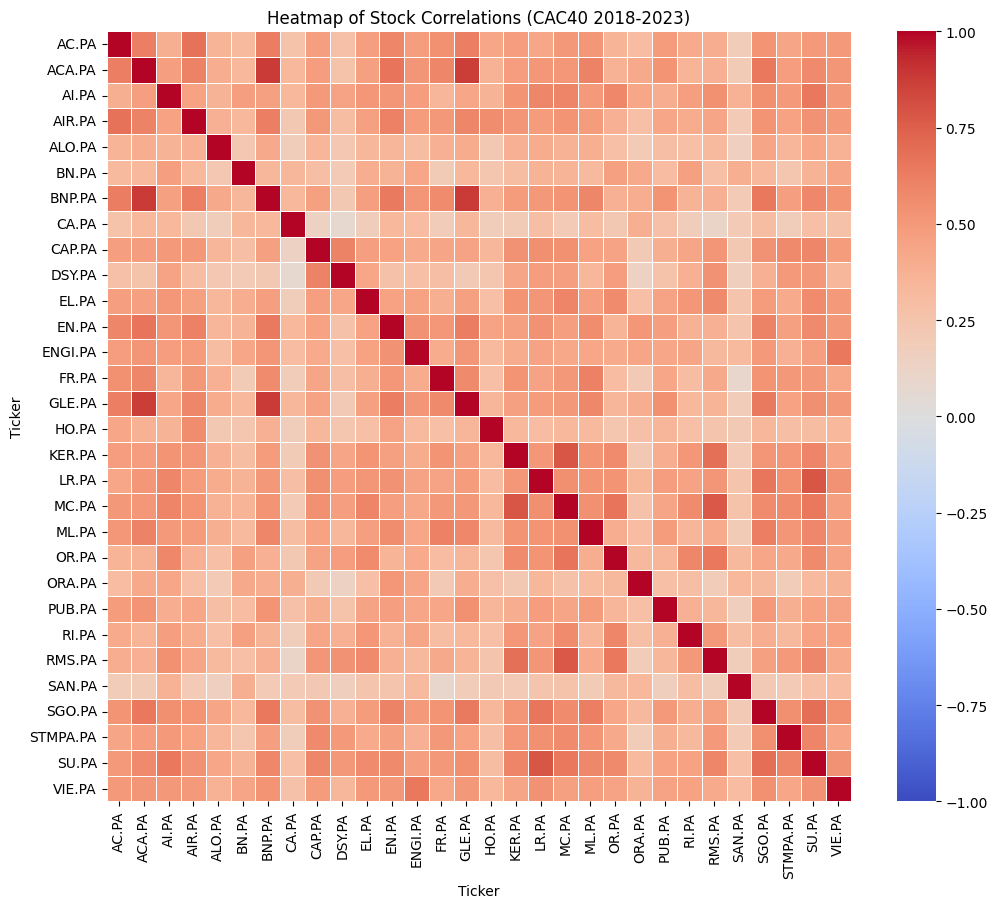

In [16]:
plot_heatmap(correlation_matrix, "Heatmap of Stock Correlations (CAC40 2018-2023)")

Based on the heatmap of CAC40 stock correlations (above), here are some observations:
- Strong Positive Correlations: 
    - Most stocks show positive correlations, with warmer colors (red tones) indicating relatively high correlations between certain stock pairs.
- Lower or Mixed Correlations: 
    - There are a few areas with lighter colors, which suggest weaker correlations between some pairs of stocks. 
    - It suggests a degree of diversification within the CAC40, meaning that not all stocks move in the same direction, which can reduce the overall volatility of the index.
- Negative Correlations: 
    - There are very few negative correlations (blue tones), indicating that it’s rare for two CAC40 stocks to move in opposite directions consistently.

Remark : The diagonal (Darker Regions - High Correlations) shows a perfect correlation (value of 1) for each stock with itself, which is expected.

In [17]:
stronger_corr(correlation_matrix)

Top 10 strongest correlations:
Ticker  Ticker
BNP.PA  GLE.PA    0.881165
GLE.PA  BNP.PA    0.881165
BNP.PA  ACA.PA    0.877714
ACA.PA  BNP.PA    0.877714
        GLE.PA    0.871025
GLE.PA  ACA.PA    0.871025
MC.PA   KER.PA    0.788303
KER.PA  MC.PA     0.788303
LR.PA   SU.PA     0.787485
SU.PA   LR.PA     0.787485
dtype: float64


Observations : 
- The pairs with the highest correlations are BNP Paribas (BNP.PA), Société Générale (GLE.PA), and Crédit Agricole (ACA.PA), which are all major financial institutions in France. These high correlations suggest that these banks tend to move similarly in response to market conditions, likely due to their shared exposure to economic factors that affect the banking sector, such as interest rates, regulatory changes, and economic cycles.
- Strong Correlations in Luxury Sector: LVMH (MC.PA) and Kering (KER.PA) show a high correlation of 0.788. They are influenced by similar market factors including consumer demand trends and economic conditions.

In [18]:
print('The first, second, and third quartiles are', np.quantile(np.array(correlation_matrix), 0.25), "&", np.quantile(np.array(correlation_matrix), 0.50), "&", np.quantile(np.array(correlation_matrix), 0.75))

return_mean = np.mean(np.array(correlation_matrix))
return_median = np.median(np.array(correlation_matrix))

# measures of dispersion
return_min = np.amin(np.array(correlation_matrix))
return_max = np.amax(np.array(correlation_matrix))
return_range = np.ptp(np.array(correlation_matrix))
return_variance = np.var(np.array(correlation_matrix))
return_std = np.std(np.array(correlation_matrix))
print("Measures of Dispersion")
print("Minimum =", return_min)
print("Maximum =", return_max)
print("Range =", return_range)
print("Variance =", return_variance)
print("Standard Deviation =", return_std)
print("Mean =", return_mean)
print("Median =", return_median)
print("First Quartile =", np.quantile(np.array(correlation_matrix), 0.25))
print("Second Quartile =", np.quantile(np.array(correlation_matrix), 0.50))
print("Third Quartile =", np.quantile(np.array(correlation_matrix), 0.75))

The first, second, and third quartiles are 0.3326053406909912 & 0.44140205202689975 & 0.5228343583400543
Measures of Dispersion
Minimum = 0.07646488771616193
Maximum = 1.0
Range = 0.9235351122838381
Variance = 0.02814664969532989
Standard Deviation = 0.16776963281634102
Mean = 0.44261178042950916
Median = 0.44140205202689975
First Quartile = 0.3326053406909912
Second Quartile = 0.44140205202689975
Third Quartile = 0.5228343583400543


Summary of Central Tendency and Dispersion : 
- Measures of Central Tendency: 
    - On average, there is a moderate positive correlation among the stocks in the CAC40 index (Mean - Average Correlation: 0.4426).
    - Q1 : 25% of the correlations are below this value, suggesting that a significant portion of stock pairs have lower correlations.
    - Q2 : The median (0.4414) is very close to the mean, suggesting a relatively symmetrical distribution of correlations around the central values.
    - Q3 : 75% of the correlations are below this level, indicating that only 25% of stock pairs exhibit correlations above 0.5228, showing stronger relationships between a minority of stocks.
- Measures of Dispersion:
    - Minimum Correlation: 0.0765
    - Maximum Correlation: 1.0 (useless infos - each stock is perfectly correlated with itself here).
    - Variance (0.0281) is relatively low, indicating that the correlation values do not vary too widely around the mean.
    - Standard Deviation (0.1678) suggests that most correlation values are moderately spread around the mean.


<a id="3b"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">The Stock Network<br></div>

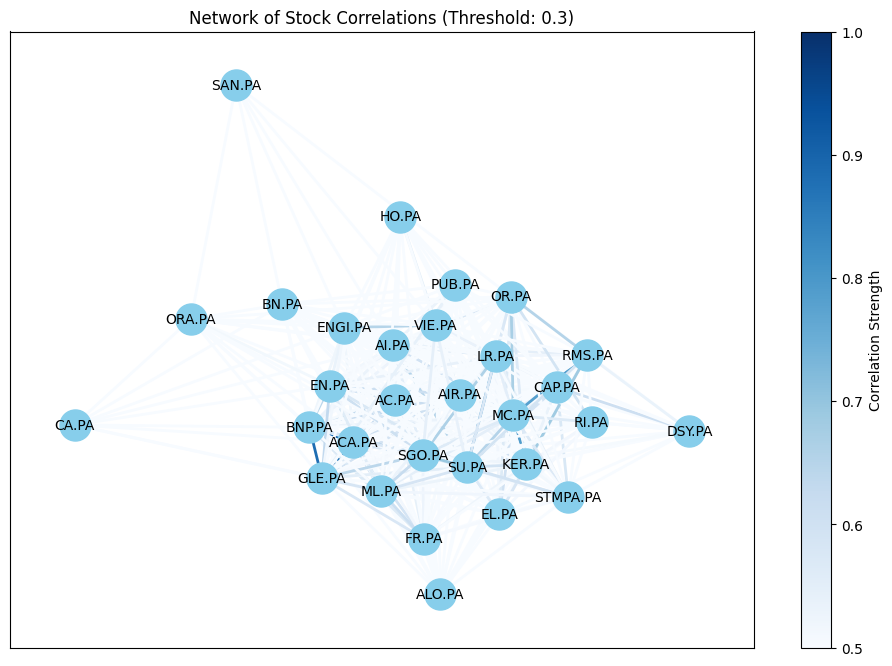

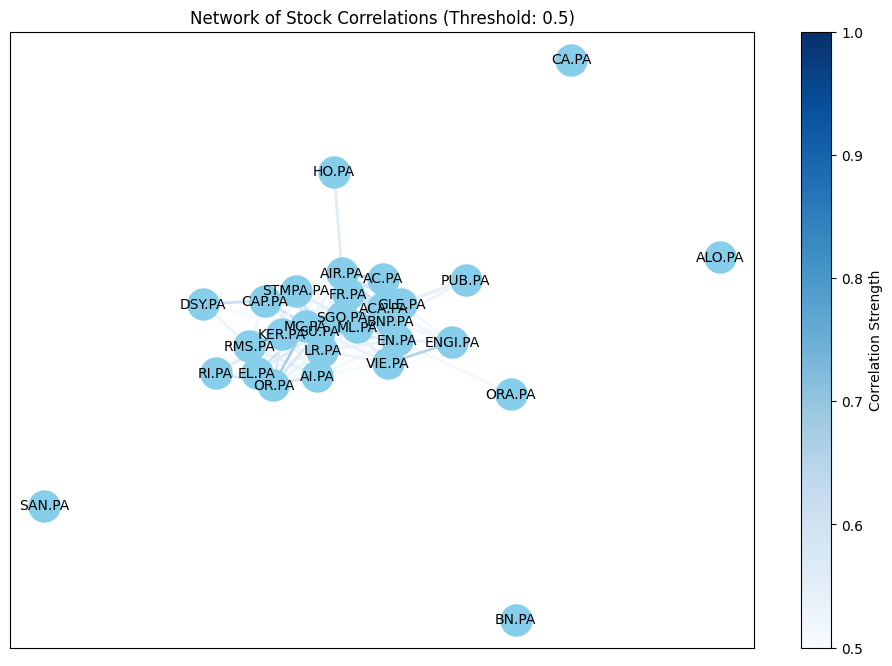

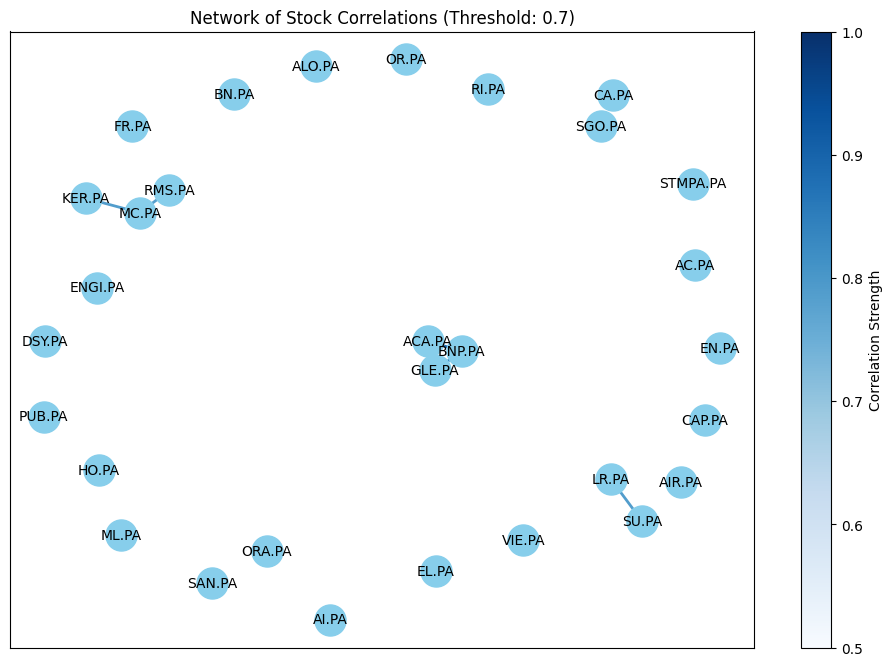

In [19]:
thresholds = [0.3, 0.5, 0.7]
for threshold in thresholds:
    G = create_correlation_network(correlation_matrix, threshold)
    visualize_correlation_network(G, threshold=threshold)

Calculons maintenant les métriques de ce réseau comme le degré moyen, la centralité de proximité, et la centralité d’intermédiarité. Ces mesures nous aideront à comprendre la structure du réseau et à identifier les actions les plus influentes.

In [20]:
G = create_correlation_network(correlation_matrix, 0.3)
degree_dict = dict(G.degree())
closeness_dict = nx.closeness_centrality(G)
betweenness_dict = nx.betweenness_centrality(G)

metrics = pd.DataFrame({
    "Degree": pd.Series(degree_dict),
    "Closeness": pd.Series(closeness_dict),
    "Betweenness": pd.Series(betweenness_dict)
}).sort_values(by="Degree", ascending=False)

metrics

,Degree,Closeness,Betweenness
AI.PA,29,1.000000,0.026049
VIE.PA,28,0.966667,0.018601
ML.PA,28,0.966667,0.013856
ENGI.PA,28,0.966667,0.021662
GLE.PA,27,0.935484,0.010291
SGO.PA,27,0.935484,0.007024
BNP.PA,27,0.935484,0.010291
LR.PA,27,0.935484,0.007024
EN.PA,27,0.935484,0.010291
ACA.PA,27,0.935484,0.010291


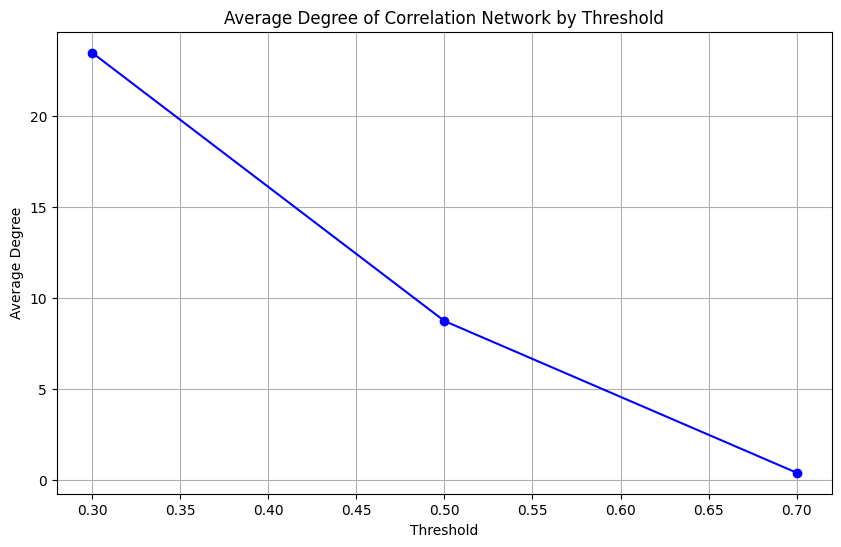

In [21]:
avg_degrees = []
    
for threshold in thresholds:
    G = create_correlation_network(correlation_matrix, threshold)
    avg_degree = sum(dict(G.degree()).values()) / len(G)
    avg_degrees.append(avg_degree)
    
plt.figure(figsize=(10, 6))
plt.plot(thresholds, avg_degrees, marker='o', color='b')
plt.xlabel("Threshold")
plt.ylabel("Average Degree")
plt.title("Average Degree of Correlation Network by Threshold")
plt.grid(True)
plt.show()

In [22]:
# Calcul du degré de chaque nœud
degrees = dict(G.degree())

# Calcul de la distribution des degrés
degree_distribution = [deg for node, deg in degrees.items()]
unique_degrees = list(set(degree_distribution))
probabilities = [degree_distribution.count(d) / len(degree_distribution) for d in unique_degrees]

print("Degrés :", degrees)
print("Distribution des degrés :", list(zip(unique_degrees, probabilities)))


Degrés : {'AC.PA': 0, 'ACA.PA': 2, 'AI.PA': 0, 'AIR.PA': 0, 'ALO.PA': 0, 'BN.PA': 0, 'BNP.PA': 2, 'CA.PA': 0, 'CAP.PA': 0, 'DSY.PA': 0, 'EL.PA': 0, 'EN.PA': 0, 'ENGI.PA': 0, 'FR.PA': 0, 'GLE.PA': 2, 'HO.PA': 0, 'KER.PA': 1, 'LR.PA': 1, 'MC.PA': 2, 'ML.PA': 0, 'OR.PA': 0, 'ORA.PA': 0, 'PUB.PA': 0, 'RI.PA': 0, 'RMS.PA': 1, 'SAN.PA': 0, 'SGO.PA': 0, 'STMPA.PA': 0, 'SU.PA': 1, 'VIE.PA': 0}
Distribution des degrés : [(0, 0.7333333333333333), (1, 0.13333333333333333), (2, 0.13333333333333333)]


In [23]:
density = nx.density(G)
print("Densité du réseau :", density)

Densité du réseau : 0.013793103448275862


In [24]:
assortativity = nx.degree_pearson_correlation_coefficient(G)
print("Assortativité du réseau :", assortativity)

Assortativité du réseau : 0.24999999999999994


In [25]:
clustering_coefficients = nx.clustering(G)
average_clustering = nx.average_clustering(G)
print("Coefficient de clustering local :", clustering_coefficients)
print("Coefficient de clustering moyen :", average_clustering)

Coefficient de clustering local : {'AC.PA': 0, 'ACA.PA': 1.0, 'AI.PA': 0, 'AIR.PA': 0, 'ALO.PA': 0, 'BN.PA': 0, 'BNP.PA': 1.0, 'CA.PA': 0, 'CAP.PA': 0, 'DSY.PA': 0, 'EL.PA': 0, 'EN.PA': 0, 'ENGI.PA': 0, 'FR.PA': 0, 'GLE.PA': 1.0, 'HO.PA': 0, 'KER.PA': 0, 'LR.PA': 0, 'MC.PA': 0, 'ML.PA': 0, 'OR.PA': 0, 'ORA.PA': 0, 'PUB.PA': 0, 'RI.PA': 0, 'RMS.PA': 0, 'SAN.PA': 0, 'SGO.PA': 0, 'STMPA.PA': 0, 'SU.PA': 0, 'VIE.PA': 0}
Coefficient de clustering moyen : 0.1


In [26]:
transitivity = nx.transitivity(G)
print("Transitivité du réseau :", transitivity)

Transitivité du réseau : 0.75


In [27]:
#average_path_length = nx.average_shortest_path_length(G)
#diameter = nx.diameter(G)
#print("Longueur de chemin moyenne :", average_path_length)
#print("Diamètre du réseau :", diameter)


In [28]:
# Degré des nœuds
degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, 'degree')

# Centralité de proximité
closeness_dict = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness_dict, 'closeness')

# Centralité d'intermédiarité
betweenness_dict = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_dict, 'betweenness')

# Affichage des métriques
metrics = pd.DataFrame({
    "Degree": pd.Series(degree_dict),
    "Closeness": pd.Series(closeness_dict),
    "Betweenness": pd.Series(betweenness_dict)
})
metrics.sort_values(by="Degree", ascending=False, inplace=True)
print(metrics)


          Degree  Closeness  Betweenness
ACA.PA         2   0.068966     0.000000
GLE.PA         2   0.068966     0.000000
MC.PA          2   0.068966     0.002463
BNP.PA         2   0.068966     0.000000
KER.PA         1   0.045977     0.000000
SU.PA          1   0.034483     0.000000
RMS.PA         1   0.045977     0.000000
LR.PA          1   0.034483     0.000000
OR.PA          0   0.000000     0.000000
ML.PA          0   0.000000     0.000000
AC.PA          0   0.000000     0.000000
ORA.PA         0   0.000000     0.000000
PUB.PA         0   0.000000     0.000000
SAN.PA         0   0.000000     0.000000
SGO.PA         0   0.000000     0.000000
STMPA.PA       0   0.000000     0.000000
RI.PA          0   0.000000     0.000000
HO.PA          0   0.000000     0.000000
FR.PA          0   0.000000     0.000000
ENGI.PA        0   0.000000     0.000000
EN.PA          0   0.000000     0.000000
EL.PA          0   0.000000     0.000000
DSY.PA         0   0.000000     0.000000
CAP.PA         0